In [1]:
import matplotlib.pyplot as plt
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np
import itertools
from glob import glob

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
import pandas as pd
import pickle
from tensorflow.keras.models import load_model
from annsa.model_classes import f1
from annsa.load_pretrained_network import load_features
from annsa.template_sampling import rebin_spectrum

Using TensorFlow backend.


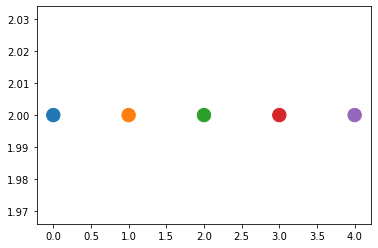

In [2]:
from aux_functions import *

# Load all models into dictionaries

In [3]:
all_models = {}
all_models_dataaug = {}

### Binarize labels, do this better

In [4]:
dataset = np.load('../dataset_generation/testing_dataset_full_200keV_100.npy')

mlb = LabelBinarizer()
keys = dataset.item()['keys']
mlb.fit(keys)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

### Load networks trained with fixed-size datasets

In [5]:
all_models = {}

trainsize = '10000'

model_classes = ['dnn', 'cnn', 'daednn', 'caednn',]

for mode in ['easy', 'full']:
    for model_class in model_classes:
        print(model_class + ' ' + mode + '...')
        temp_models = []
        for i in range(5):
            i = str(i)
            identifier = '-final_trainsize'
            if model_classes == 'cnn':
                identifier = '-final-reluupdate_trainsize'

            temp_model = load_model(
                os.path.join('..',
                'final_training_notebooks',
                'final-models-keras',
                'learningcurve-'+model_class+'-'+mode+identifier+trainsize+'_fold'+i+'.hdf5',),
                custom_objects={'f1': f1},
                compile=False,
            )
            temp_models.append(temp_model)
        all_models[model_class+'-'+mode] = temp_models

scalers = {}
model_classes = ['dnn', 'cnn',]
for mode in ['easy', 'full']:
    for model_class in model_classes:
        architecture_id = '../final_training_notebooks/final-models/learningcurve-'+model_class+'-'+mode+'-final-features'
        model_features = load_features(architecture_id)
        scalers[model_class+'-'+mode] = model_features.scaler.transform
        if model_class == 'dnn':
            scalers['daednn'+'-'+mode] = model_features.scaler.transform
        if model_class == 'cnn':
            scalers['caednn'+'-'+mode] = model_features.scaler.transform


dnn easy...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
cnn easy...
daednn easy...
caednn easy...
dnn full...
cnn full...
daednn full...
caednn full...


In [6]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


def results2(res, number_isotopes_displayed):

    index = [i[0] for i in sorted(enumerate(res), key=lambda x:x[1])]
    index = list(reversed(index))
    for i in range(number_isotopes_displayed):
        print((mlb.classes_[index[i]], round(res[index[i]], 3)))
        
        
def models_bagged_probs(all_models, model_id, spectra):
    '''
    Bags a specific model's output from a dictionary of models.

    Inputs
        all_models : dict
            Dictionary containing all models
        model_id : string
            Specific model identifier such as 'dnn-full' or 'cae-easy'.
        spectra : numpy array
            Array containing multiple gamma-ray spectra

    Outputs
        output_mode : int
            The most frequent occuring output from the bagged model.
        output : list, int
            A list of outputs from each bagged model.
    '''
    output = []
    for model in all_models:

        if model_id in model:
            tmp_model = all_models[model]
            tmp_output = 100*softmax(tmp_model.forward_pass(spectra, training=False).numpy().flatten())
            output.append(tmp_output)

    output_mode = np.average(output, axis=0)

    return output_mode, output

In [7]:
def predictions_from_bagged_model(all_models,
                                  model_id,
                                  spectra,
                                  classes,
                                  num_isotopes=5,
                                  ):
    
    bagged_probs, _ = models_bagged_probs(all_models, model_id, spectra)
    output_probs_classes = [(x, y) for x, y in zip(bagged_probs, classes)]
    output_probs_classes_sorted = sorted(output_probs_classes, reverse=True)
    
    for i in range(num_isotopes):
        print('%.1f' % output_probs_classes_sorted[i][0],
              output_probs_classes_sorted[i][1])
    print('\n')
    

# Create results dataframe 

In [8]:
dataframe_data = []

In [9]:
isotope = 'eu152' # mlb.classes_[8]

pmt_gains = ['720v', '745v', '770v', '795v', '820v']
sb_ratios = [0.5, 1.0]

for sb_ratio in sb_ratios:
    for pmt_gain in pmt_gains:
        print(pmt_gain, sb_ratio, end='\r')
        spectra = []
        for path in glob('../training_testing_data/'+isotope+'_SB-'+str(sb_ratio)+'/detector129_'+pmt_gain+'_10s_*'):
            spectra.append(read_spectrum(path))
        spectra_cumsum = np.cumsum(spectra, axis=0)
        all_output_probs = []

        for model_class in ['dnn', 'cnn', 'daednn', 'caednn',]:
            for mode in ['-easy', '-full']:
                all_output_probs = []
                model_id = model_class + mode
                for i in range(30):
                    bagged_probs = ensemble_probas(all_models[model_id], scalers[model_id], [spectra_cumsum[i]])
                    all_output_probs.append(bagged_probs)

                dataframe_data.append([model_id, sb_ratio, pmt_gain, isotope, all_output_probs])

spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown e

In [10]:
isotope = 'co60' # mlb.classes_[8]

pmt_gains = ['720v', '745v', '770v', '795v', '820v']
sb_ratios = [0.5, 1.0]

for sb_ratio in sb_ratios:
    for pmt_gain in pmt_gains:
        print(pmt_gain, sb_ratio, end='\r')
        spectra = []
        for path in glob('../training_testing_data/'+isotope+'_SB-'+str(sb_ratio)+'/detector129_'+pmt_gain+'_10s_*'):
            spectra.append(read_spectrum(path))
        spectra_cumsum = np.cumsum(spectra, axis=0)

        
        for model_class in ['dnn', 'cnn', 'daednn', 'caednn',]:
            for mode in ['-easy', '-full']:
                all_output_probs = []
                model_id = model_class + mode
                for i in range(30):
                    bagged_probs = ensemble_probas(all_models[model_id], scalers[model_id], [spectra_cumsum[i]])
                    all_output_probs.append(bagged_probs)

                dataframe_data.append([model_id, sb_ratio, pmt_gain, isotope, all_output_probs])

spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown e

In [11]:
isotope = 'ba133' # mlb.classes_[8]

pmt_gains = ['720v', '745v', '770v', '820v']
sb_ratios = [0.5, 1.0]


for sb_ratio in sb_ratios:
    for pmt_gain in pmt_gains:
        print(pmt_gain, sb_ratio, end='\r')
        spectra = []
        for path in glob('../training_testing_data/'+isotope+'_SB-'+str(sb_ratio)+'/detector129_'+pmt_gain+'_10s_*'):
            spectra.append(read_spectrum(path))
        spectra_cumsum = np.cumsum(spectra, axis=0)

        
        for model_class in ['dnn', 'cnn', 'daednn', 'caednn',]:
            for mode in ['-easy', '-full']:
                all_output_probs = []
                model_id = model_class + mode
                for i in range(30):
                    bagged_probs = ensemble_probas(all_models[model_id], scalers[model_id], [spectra_cumsum[i]])
                    all_output_probs.append(bagged_probs)

                dataframe_data.append([model_id, sb_ratio, pmt_gain, isotope, all_output_probs])

spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown e

In [12]:
isotope = 'cs137' # mlb.classes_[8]

pmt_gains = ['720v', '745v', '770v', '795v', '820v']
sb_ratios = [0.5, 1.0]

for sb_ratio in sb_ratios:
    for pmt_gain in pmt_gains:
        print(pmt_gain, sb_ratio, end='\r')
        spectra = []
        for path in glob('../training_testing_data/'+isotope+'_SB-'+str(sb_ratio)+'/detector129_'+pmt_gain+'_10s_*'):
            spectra.append(read_spectrum(path))
        spectra_cumsum = np.cumsum(spectra, axis=0)
        

        
        for model_class in ['dnn', 'cnn', 'daednn', 'caednn',]:
            for mode in ['-easy', '-full']:
                all_output_probs = []
                model_id = model_class + mode
                for i in range(30):
                    bagged_probs = ensemble_probas(all_models[model_id], scalers[model_id], [spectra_cumsum[i]])
                    all_output_probs.append(bagged_probs)

                dataframe_data.append([model_id, sb_ratio, pmt_gain, isotope, all_output_probs])

spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown e

### Make data to fill in missing spectra of ba133 at 795v at sb_ratio of 0.5

In [13]:
isotope = 'ba133' # mlb.classes_[8]

pmt_gains = ['795v']
sb_ratios = [0.5]


for sb_ratio in sb_ratios:
    for pmt_gain in pmt_gains:
        print(pmt_gain, sb_ratio, end='\r')
        spectra = []
        for path in glob('../training_testing_data/'+isotope+'_SB-'+str(sb_ratio)+'/detector129_'+'770v'+'_10s_*'):
            spectra.append(rebin_spectrum(np.array(read_spectrum(path)), a=0, b=1/1.27, c=0))           
        spectra_cumsum = np.cumsum(spectra, axis=0)

        
        for model_class in ['dnn', 'cnn', 'daednn', 'caednn',]:
            for mode in ['-easy', '-full']:
                all_output_probs = []
                model_id = model_class + mode
                for i in range(30):
                    bagged_probs = ensemble_probas(all_models[model_id], scalers[model_id], [spectra_cumsum[i]])
                    all_output_probs.append(bagged_probs)

                dataframe_data.append([model_id, sb_ratio, pmt_gain, isotope, all_output_probs])

spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding


In [14]:
isotope = 'ba133' # mlb.classes_[8]

pmt_gains = ['795v']
sb_ratios = [1.0]


for sb_ratio in sb_ratios:
    for pmt_gain in pmt_gains:
        print(pmt_gain, sb_ratio, end='\r')
        spectra = []
        for path in glob('../training_testing_data/'+isotope+'_SB-'+str(sb_ratio)+'/detector129_'+pmt_gain+'_10s_*'):
            spectra.append(read_spectrum(path))
        spectra_cumsum = np.cumsum(spectra, axis=0)
        
        for model_class in ['dnn', 'cnn', 'daednn', 'caednn',]:
            for mode in ['-easy', '-full']:
                all_output_probs = []
                model_id = model_class + mode
                for i in range(30):
                    bagged_probs = ensemble_probas(all_models[model_id], scalers[model_id], [spectra_cumsum[i]])
                    all_output_probs.append(bagged_probs)

                dataframe_data.append([model_id, sb_ratio, pmt_gain, isotope, all_output_probs])

spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding


### Save data in dataframe

In [15]:
columns = ['model_id', 'sb_ratio', 'pmt_gain', 'isotope', 'posterior_prob']

results_dataframe = pd.DataFrame(dataframe_data, columns=columns)

# results_dataframe.to_pickle('measured_sources_gain_performance_dataaug')

## Relative gain shift calculation

In [16]:
spectra = {}
pmt_gains = ['720v', '745v', '770v', '795v', '820v']


for pmt_gain in pmt_gains:
    spectra[pmt_gain] = np.zeros(1024)
    for path in glob('../training_testing_data/cs137_SB-1.0/detector129_'+pmt_gain+'_10s_*'):
        spectra[pmt_gain] += read_spectrum(path)


spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown e

141
185
237
301
379


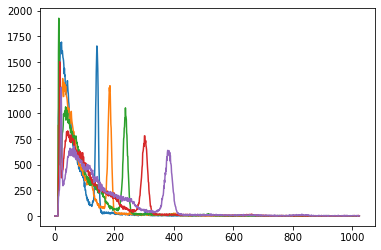

In [17]:
centroids = {}

for pmt_gain in pmt_gains:
    plt.plot(spectra[pmt_gain])
    print(100+np.argmax(spectra[pmt_gain][100:]))
    centroids[pmt_gain] = 100+np.argmax(spectra[pmt_gain][100:])

(0.01, 10000.0)

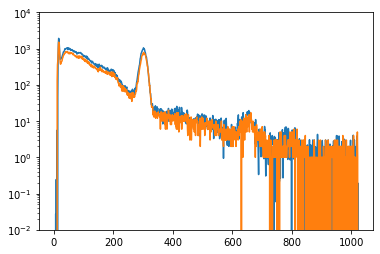

In [18]:
plt.plot(rebin_spectrum(spectra['770v'], a=0, b=1/1.27, c=0))
plt.plot(spectra['795v'])
plt.semilogy()
plt.ylim([1e-2,1e4])

In [19]:
for pmt_gain in pmt_gains:
    print(centroids[pmt_gain]/centroids['745v'])

0.7621621621621621
1.0
1.281081081081081
1.627027027027027
2.0486486486486486


# Plot all images

In [20]:
def make_blank_plot():

    plt.rcParams.update({'font.size': 20})
    fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(16,9))

    for ax in axs:
        for subax in ax:
            subax.set_ylim([0,110])

    axs[0, 0].set_title('S:B = 0.5')
    axs[0, 1].set_title('S:B = 1.0')

    axs[1, 0].set_xlabel('Integration Time (s)')
    axs[1, 1].set_xlabel('Integration Time (s)')

    axs[0, 0].set_ylabel('Dataset: Simple \n Posterior Probability')
    axs[1, 0].set_ylabel('Dataset: Complete \n Posterior Probability')
    
    return fig, axs

In [21]:
def plot_measured_source_results(results_dataframe,
                                 isotope,
                                 gadras_isotope,
                                 sb_ratio,
                                 setting,
                                 pmt_gains,):
    gadras_index = np.argwhere(mlb.classes_ == gadras_isotope).flatten()[0]
    for option_index, pmt_gain in enumerate(pmt_gains):
        for model_idindex, model_id in enumerate(['caednn-'+setting,
                                                  'daednn-'+setting,
                                                  'dnn-'+setting,
                                                  'cnn-'+setting,]):
            results_dataframe_tmp = results_dataframe[results_dataframe['model_id'] == model_id]
            results_dataframe_tmp = results_dataframe_tmp[results_dataframe_tmp['sb_ratio'] == sb_ratio]
            results_dataframe_tmp = results_dataframe_tmp[results_dataframe_tmp['isotope'] == isotope]
            results_dataframe_tmp = results_dataframe_tmp[results_dataframe_tmp['pmt_gain'] == pmt_gain]

            if setting == 'easy':
                setting_index = 0
            else:
                setting_index = 1

            if sb_ratio == 0.5:
                sb_ratio_index = 0
            else:
                sb_ratio_index = 1
            
            axs[setting_index][sb_ratio_index].plot(
                np.linspace(10,300,30),
                100*np.array(results_dataframe_tmp['posterior_prob'].values[0]).reshape(30,30)[:,gadras_index], 
                label=pmt_gain,
                linewidth=2.5,
                linestyle=linestyles[option_index],
                color=c1.colors[model_idindex],)  
    

In [22]:
isotopes = []
sb_ratios = []
pmt_gains = []
all_spectra = []

In [23]:
save_fig = True
plot_title = True

# Define plot params

In [24]:
from matplotlib.lines import Line2D

line_colors = {'caednn' : c1.colors[0],
               'daednn' : c1.colors[1],
               'dnn' : c1.colors[2],
               'cnn' : c1.colors[3],
              }

linestyles = ['-', '--', '-.', ':']

custom_lines = [Line2D([0], [0], color=c1.colors[3], lw=4),
                Line2D([0], [0], color='k', linestyle=linestyles[0], markersize=15, lw=3),
                Line2D([0], [0], color=c1.colors[2], lw=4),
                Line2D([0], [0], color='k', linestyle=linestyles[1], markersize=15, lw=3),
                Line2D([0], [0], color=c1.colors[0], lw=4),
                Line2D([0], [0], color='k', linestyle=linestyles[2], markersize=15, lw=3),
                Line2D([0], [0], color=c1.colors[1], lw=4),
                Line2D([0], [0], color='k', linestyle=linestyles[3], markersize=15, lw=3),
               ]

loc = (-0.65,-0.55)
legend_font_size = 20

## Eu152

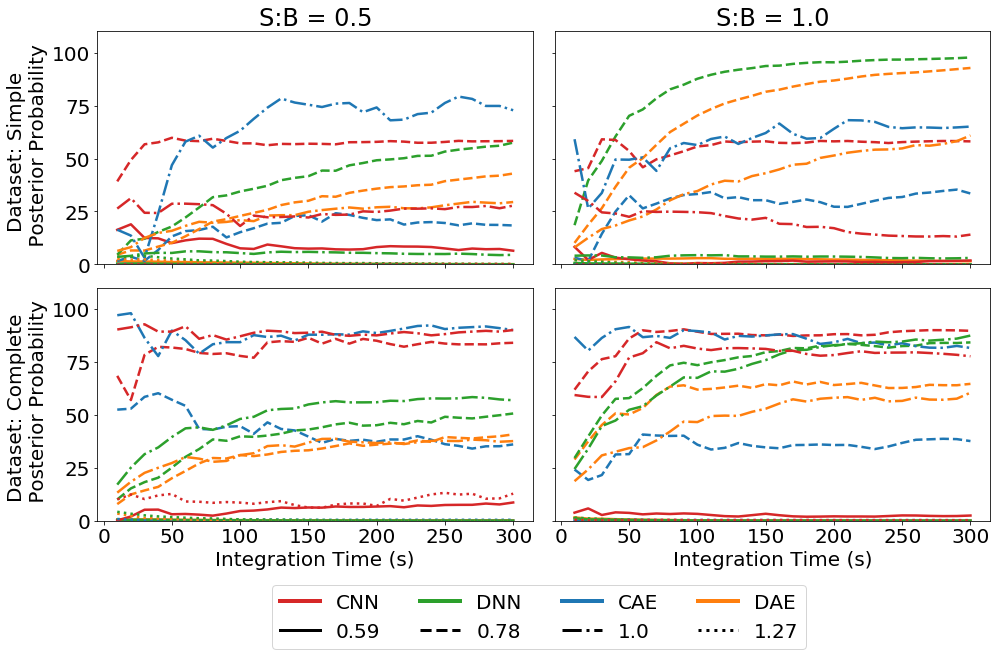

In [25]:
isotope = 'eu152'
gadras_isotope = '152EU'


fig, axs = make_blank_plot()

ax = plt.gca()
ax.legend(custom_lines,
           ['CNN', '0.59', 'DNN', '0.78', 'CAE', '1.0', 'DAE', '1.27'], 
           loc=loc,
           ncol=4,
           prop={'size': legend_font_size},
           )


for sb_ratio in [0.5, 1.0]:
    for setting in ['easy', 'full']:
        plot_measured_source_results(results_dataframe=results_dataframe,
                                     isotope=isotope,
                                     gadras_isotope=gadras_isotope,
                                     sb_ratio=sb_ratio,
                                     setting=setting,
                                     pmt_gains=['720v', '745v', '770v', '795v'],)

fig.subplots_adjust(wspace=0.05, hspace=0.1)
if save_fig:
    plt.savefig('realspectra-cal-'+isotope,
                bbox_inches='tight')

In [26]:
for sb_ratio in ['0.5', '1.0']:
    for pmt_gain in ['720v', '745v', '770v', '795v']:
        spectra = []
        for path in glob(os.path.join('..',
                                      'training_testing_data',
                                      isotope+'_SB-'+sb_ratio,
                                      'detector129_'+pmt_gain+'_10s_*')):
            spectra.append(read_spectrum(path))
            
        isotopes.append(isotope)
        sb_ratios.append(sb_ratio)
        pmt_gains.append(pmt_gain)
        all_spectra.append(np.cumsum(spectra,
                                     axis=0))


spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown e

## Ba133

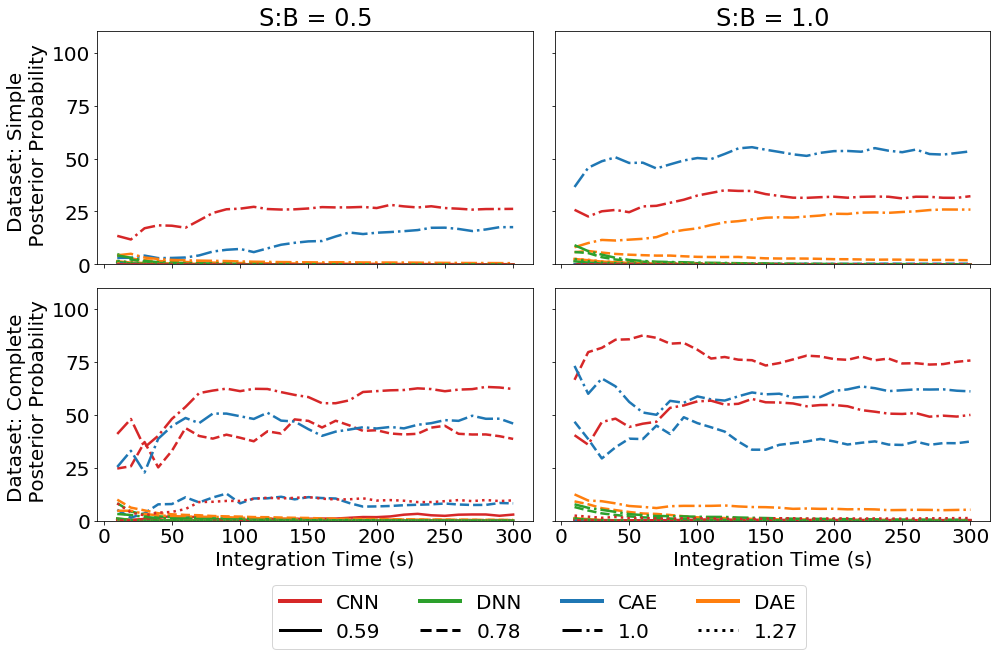

In [27]:
isotope = 'ba133'
gadras_isotope = '133BA'

fig, axs = make_blank_plot()

ax = plt.gca()
ax.legend(custom_lines,
           ['CNN', '0.59', 'DNN', '0.78', 'CAE', '1.0', 'DAE', '1.27'], 
           loc=loc,
           ncol=4,
           prop={'size': legend_font_size},
           )


for sb_ratio in [0.5, 1.0]:
    for setting in ['easy', 'full']:
        plot_measured_source_results(results_dataframe=results_dataframe,
                                     isotope=isotope,
                                     gadras_isotope=gadras_isotope,
                                     sb_ratio=sb_ratio,
                                     setting=setting,
                                     pmt_gains=['720v', '745v', '770v', '795v'],)

fig.subplots_adjust(wspace=0.05, hspace=0.1)
if save_fig:
    plt.savefig('realspectra-cal-'+isotope,
                bbox_inches='tight')
            
            

In [28]:
for sb_ratio in ['0.5', '1.0']:
    for pmt_gain in ['720v', '745v', '770v', '795v']:
        spectra = []
        if sb_ratio == '0.5' and pmt_gain == '795v':        
            pmt_gain = '770v'
            for path in glob(os.path.join('..',
                              'training_testing_data',
                              isotope+'_SB-'+sb_ratio,
                              'detector129_'+pmt_gain+'_10s_*')):
                spectra.append(rebin_spectrum(np.array(read_spectrum(path)), a=0, b=1/1.27, c=0))    

        else:
            for path in glob(os.path.join('..',
                                          'training_testing_data',
                                          isotope+'_SB-'+sb_ratio,
                                          'detector129_'+pmt_gain+'_10s_*')):
                spectra.append(read_spectrum(path))
            
        isotopes.append(isotope)
        sb_ratios.append(sb_ratio)
        pmt_gains.append(pmt_gain)
        all_spectra.append(np.cumsum(spectra,
                                     axis=0))


spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown e

## Co60

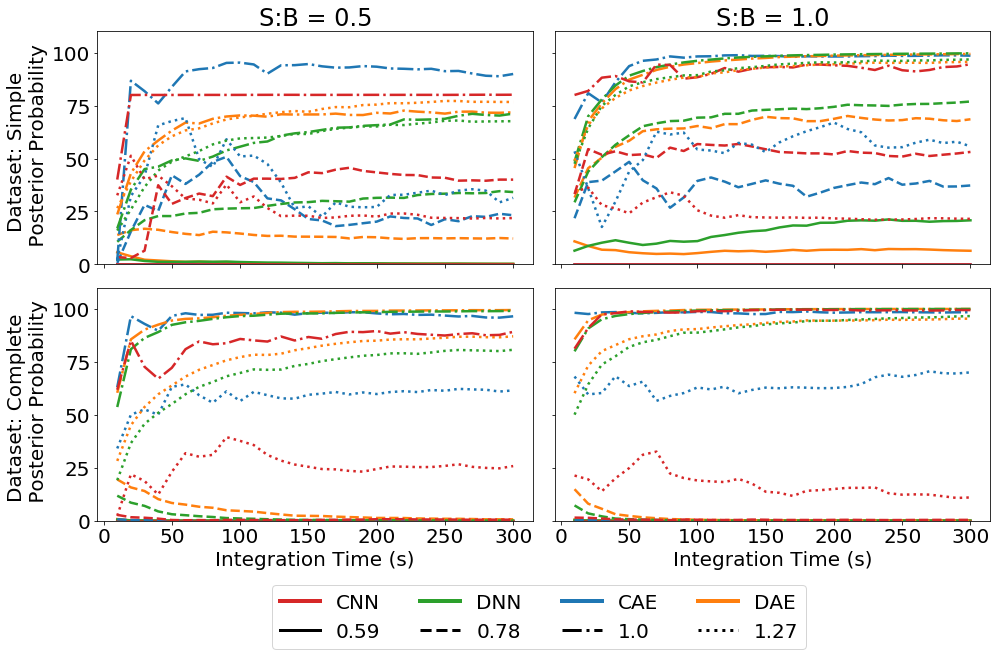

In [29]:
isotope = 'co60'
gadras_isotope = '60CO'

fig, axs = make_blank_plot()

ax = plt.gca()
ax.legend(custom_lines,
           ['CNN', '0.59', 'DNN', '0.78', 'CAE', '1.0', 'DAE', '1.27'], 
           loc=loc,
           ncol=4,
           prop={'size': legend_font_size},
           )


for sb_ratio in [0.5, 1.0]:
    for setting in ['easy', 'full']:
        plot_measured_source_results(results_dataframe=results_dataframe,
                                     isotope=isotope,
                                     gadras_isotope=gadras_isotope,
                                     sb_ratio=sb_ratio,
                                     setting=setting,
                                     pmt_gains=['720v', '745v', '770v', '795v'],)

fig.subplots_adjust(wspace=0.05, hspace=0.1)
if save_fig:
    plt.savefig('realspectra-cal-'+isotope,
                bbox_inches='tight')
            
            

In [30]:
for sb_ratio in ['0.5', '1.0']:
    for pmt_gain in ['720v', '745v', '770v', '795v']:
        spectra = []
        for path in glob(os.path.join('..',
                                      'training_testing_data',
                                      isotope+'_SB-'+sb_ratio,
                                      'detector129_'+pmt_gain+'_10s_*')):
            spectra.append(read_spectrum(path))
            
        isotopes.append(isotope)
        sb_ratios.append(sb_ratio)
        pmt_gains.append(pmt_gain)
        all_spectra.append(np.cumsum(spectra,
                                     axis=0))


spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown e

## Cs137

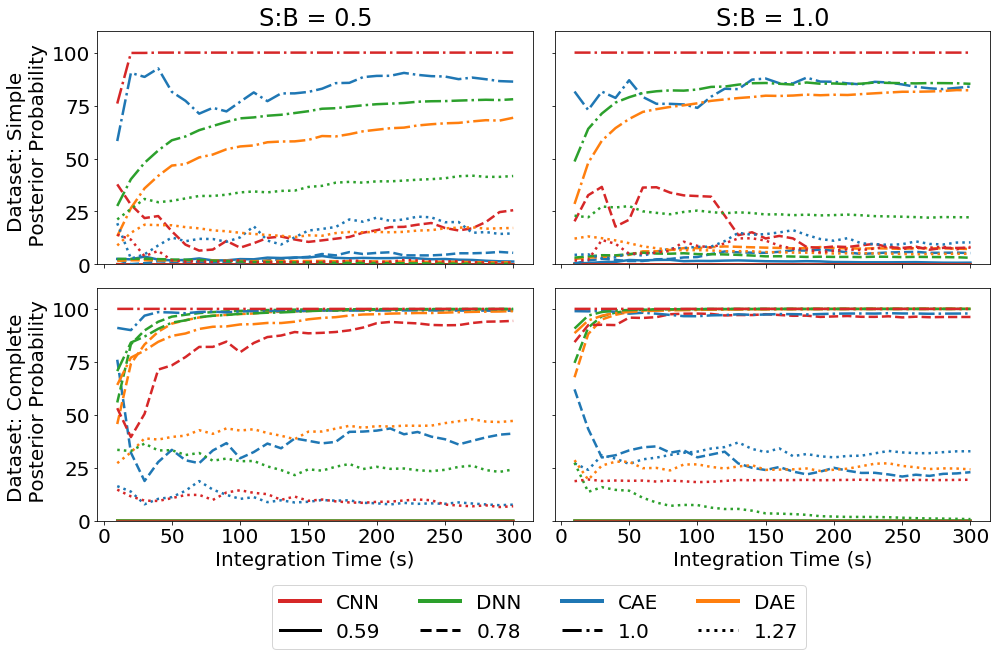

In [31]:
isotope = 'cs137'
gadras_isotope = '137CS'

fig, axs = make_blank_plot()

ax = plt.gca()
ax.legend(custom_lines,
           ['CNN', '0.59', 'DNN', '0.78', 'CAE', '1.0', 'DAE', '1.27'], 
           loc=loc,
           ncol=4,
           prop={'size': legend_font_size},
           )


for sb_ratio in [0.5, 1.0]:
    for setting in ['easy', 'full']:
        plot_measured_source_results(results_dataframe=results_dataframe,
                                     isotope=isotope,
                                     gadras_isotope=gadras_isotope,
                                     sb_ratio=sb_ratio,
                                     setting=setting,
                                     pmt_gains=['720v', '745v', '770v', '795v'],)

fig.subplots_adjust(wspace=0.05, hspace=0.1)
if save_fig:
    plt.savefig('realspectra-cal-'+isotope,
                bbox_inches='tight')
            
            

In [32]:
for sb_ratio in ['0.5', '1.0']:
    for pmt_gain in ['720v', '745v', '770v', '795v']:
        spectra = []
        for path in glob(os.path.join('..',
                                      'training_testing_data',
                                      isotope+'_SB-'+sb_ratio,
                                      'detector129_'+pmt_gain+'_10s_*')):
            spectra.append(read_spectrum(path))
            
        isotopes.append(isotope)
        sb_ratios.append(sb_ratio)
        pmt_gains.append(pmt_gain)
        all_spectra.append(np.cumsum(spectra,
                                     axis=0))


spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown encoding
spe in unknown e

# Plot spectra

In [33]:
data = {'isotope': isotopes,
        'sb_ratio': sb_ratios,
        'pmt_gain': pmt_gains,
        'spectra' : all_spectra}
spectra_dataframe = pd.DataFrame.from_dict(data)
 

In [82]:
spectrum_colors = [
    'fuchsia',
    'green',
    'fuchsia',
    'green',
    ]

custom_lines_spectra = [
    Line2D([0], [0], color=spectrum_colors[0], lw=4),
    Line2D([0], [0], color=spectrum_colors[1], lw=4),
    ]

sb_ratios = ['0.5', '1.0']

In [83]:
energy_calibration = 2.98443*np.arange(1024)-23.7

In [84]:
spectra_dataframe.head()

,isotope,sb_ratio,pmt_gain,spectra
0,eu152,0.5,720v,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 14, 44, 30,..."
1,eu152,0.5,745v,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 56, 63,..."
2,eu152,0.5,770v,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 12, 17, ..."
3,eu152,0.5,795v,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 5, 7, 12..."
4,eu152,1.0,720v,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 44, 44, 28,..."


In [37]:
spectra_dataframe_tmp = spectra_dataframe[spectra_dataframe['isotope'] == 'eu152']

In [38]:
spectra_dataframe_tmp

,isotope,sb_ratio,pmt_gain,spectra
0,eu152,0.5,720v,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 14, 44, 30,..."
1,eu152,0.5,745v,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 56, 63,..."
2,eu152,0.5,770v,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 12, 17, ..."
3,eu152,0.5,795v,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 5, 7, 12..."
4,eu152,1.0,720v,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 44, 44, 28,..."
5,eu152,1.0,745v,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 28, 141, 13..."
6,eu152,1.0,770v,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 16, 24, ..."
7,eu152,1.0,795v,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 6, 10..."


In [39]:
spectra_dataframe_tmp[spectra_dataframe_tmp['sb_ratio'] == '0.5']

,isotope,sb_ratio,pmt_gain,spectra
0,eu152,0.5,720v,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 14, 44, 30,..."
1,eu152,0.5,745v,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 56, 63,..."
2,eu152,0.5,770v,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 12, 17, ..."
3,eu152,0.5,795v,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 5, 7, 12..."


In [40]:
def plot_spec(isotope):
    
    plt.figure(figsize=(9,4))
    plt.plot(energy_calibration, spectra_cumsum_10[isotope][0], color = spectrum_colors[0])
    plt.plot(energy_calibration, spectra_cumsum_05[isotope][0], color = spectrum_colors[1])
    plt.plot(energy_calibration, spectra_cumsum_10[isotope][-1], color = spectrum_colors[0])
    plt.plot(energy_calibration, spectra_cumsum_05[isotope][-1], color = spectrum_colors[1])
    plt.semilogy()
    plt.ylabel('Counts per Channel')
    plt.xlabel('Energy (keV)')
    plt.ylim([7e-1, 5e3])
    plt.legend(custom_lines_spectra,
              sb_ratios, 
              prop={'size': 15},
              )

In [41]:
spectra_dataframe_tmp.sample()['spectra'].values[0][-1]

array([0, 0, 0, ..., 0, 0, 0])

In [42]:
662 *0.8

529.6

In [43]:
1001-766

235

In [44]:
1173-1332

-159

In [45]:
spectra_dataframe2 = spectra_dataframe[spectra_dataframe['isotope']=='ba133']
# sb_ratio = '0.5'
sb_ratio = '1.0'

# pmt_gain = '720v'
# pmt_gain = '745v'
# pmt_gain = '770v'
pmt_gain = '795v'
# spec_index = 0
spec_index = 6

spectra_dataframe_tmp = spectra_dataframe2[spectra_dataframe2['sb_ratio'] == sb_ratio]
spectra_dataframe_tmp = spectra_dataframe_tmp[spectra_dataframe_tmp['pmt_gain'] == pmt_gain]

for mode in ['-easy', '-full']:
    for model_class in ['cnn', 'dnn', 'caednn', 'daednn',]:
        all_output_probs = []
        model_id = model_class + mode
#         for spec in spectra_dataframe_tmp['spectra'].values[0]:
#             bagged_probs = ensemble_probas(
#                 all_models[model_id],
#                 scalers[model_id],
#                 [spec],)
#             print(model_class + mode,np.max(bagged_probs), mlb.classes_[np.argmax(bagged_probs)])
        
        spec = spectra_dataframe_tmp['spectra'].values[0][spec_index]
        bagged_probs = ensemble_probas(
            all_models[model_id],
            scalers[model_id],
            [spec],)
        print(model_class + mode,np.max(bagged_probs), mlb.classes_[np.argmax(bagged_probs)])




cnn-easy 0.7258673 241AM
dnn-easy 0.35007447 137CS
caednn-easy 0.51813793 240PU
daednn-easy 0.25190037 226RA
cnn-full 0.25613952 240PU
dnn-full 0.27571863 192IR
caednn-full 0.32112032 103PD
daednn-full 0.5070385 137CS


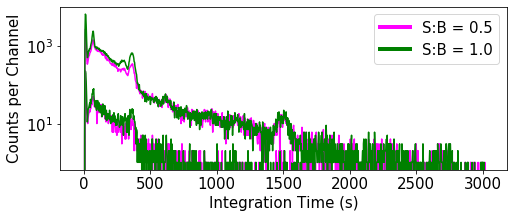

In [95]:
spectra_dataframe2 = spectra_dataframe[spectra_dataframe['isotope']=='ba133']

sb_ratios_legend = ['S:B = 0.5',
                    'S:B = 1.0']

plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(8,3))

for spec_index in [0, -1]:
    for sb_ratio_index, sb_ratio in enumerate(['0.5', '1.0']):
        for pmt_gain in ['770v']:
            spectra_dataframe_tmp = spectra_dataframe2[spectra_dataframe2['sb_ratio'] == sb_ratio]
            spectra_dataframe_tmp = spectra_dataframe_tmp[spectra_dataframe_tmp['pmt_gain'] == pmt_gain]

            plt.semilogy(
                energy_calibration,
                spectra_dataframe_tmp['spectra'].values[0][spec_index],
                color=spectrum_colors[sb_ratio_index],)

plt.semilogy()
plt.ylabel('Counts per Channel')
plt.xlabel('Energy (keV)')

plt.xlabel('Integration Time (s)')
plt.ylabel('Counts per Channel')

plt.legend(custom_lines_spectra,
          sb_ratios_legend, 
          prop={'size': 15},
          )

In [88]:
sb_ratios

['0.5', '1.0']